In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
password = getpass.getpass()

········


In [2]:
# 1. Create a query or queries to extract the information you think may be relevant for building the prediction model.
# It should include some film features and some rental features (X).
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query1 = '''SELECT DISTINCT(title) AS rented_in_may FROM sakila.film
LEFT JOIN sakila.inventory
USING (film_id)
LEFT JOIN sakila.rental
USING (inventory_id)
WHERE rental_date BETWEEN "2005-05-01%%" AND "2005-05-31%%"'''

query2='''SELECT f.film_id, f.title, f.rental_duration, f.rental_rate, c.category_id, c.name AS category FROM sakila.film f
LEFT JOIN film_category
USING (film_id)
LEFT JOIN category c
USING (category_id);'''

In [3]:
data1 = pd.read_sql_query(query1, engine)
data1.head()

,rented_in_may
0,BLANKET BEVERLY
1,FREAKY POCUS
2,GRADUATE LORD
3,LOVE SUICIDES
4,IDOLS SNATCHERS


In [4]:
# 3. Read the data into a Pandas dataframe. At this point you should have 1000 rows. 
# Number of columns depends on the number of features you chose.
data2 =pd.read_sql_query(query2, engine)
display(data2.head())
data2.shape

,film_id,title,rental_duration,rental_rate,category_id,category
0,1,ACADEMY DINOSAUR,6,0.99,6,Documentary
1,2,ACE GOLDFINGER,3,4.99,11,Horror
2,3,ADAPTATION HOLES,7,2.99,6,Documentary
3,4,AFFAIR PREJUDICE,5,2.99,11,Horror
4,5,AFRICAN EGG,6,2.99,8,Family


(1000, 6)

In [5]:
# 2. Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. 
# (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.
data2['rented_in_may'] = np.where(data2['title'].isin (data1['rented_in_may']) ,1,0)



In [6]:
data2 = data2.drop(['film_id','title','category_id'], axis=1)
data2.head()

,rental_duration,rental_rate,category,rented_in_may
0,6,0.99,Documentary,1
1,3,4.99,Horror,0
2,7,2.99,Documentary,0
3,5,2.99,Horror,1
4,6,2.99,Family,1


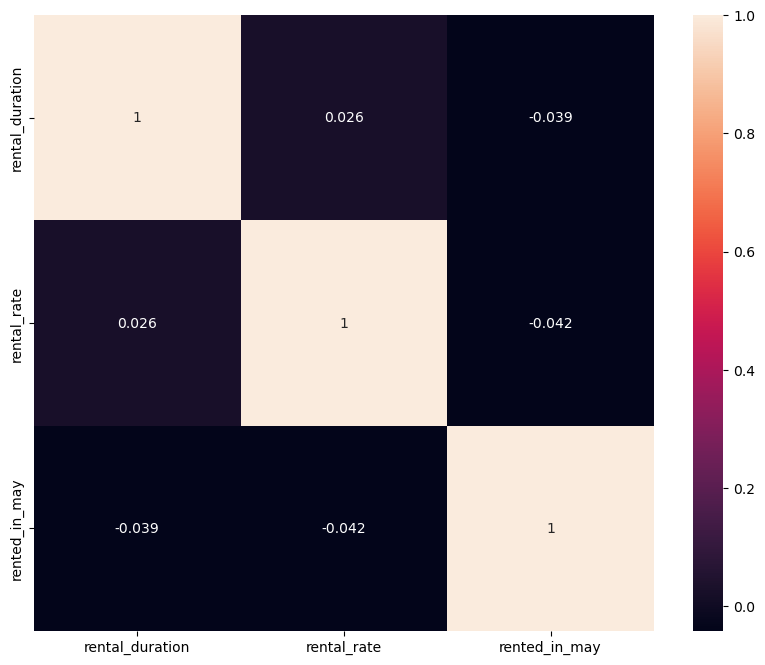

In [7]:
# 4. Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.
corr_matrix=data2.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [8]:
y = data2['rented_in_may']
X = data2.drop('rented_in_may', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [9]:
from sklearn.preprocessing import MinMaxScaler
X_train_num = X_train.select_dtypes(include = np.number)
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)

X_train_norm.columns = X_train_num.columns

In [10]:
X_train_categorical = X_train.select_dtypes(include = np.object)
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['category'],
                             drop_first=True)
X_train_cat.head()

C:\Users\gorka\AppData\Local\Temp\ipykernel_13988\221867575.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train_categorical = X_train.select_dtypes(include = np.object)


,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
246,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
771,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
790,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
936,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
261,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [11]:
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

In [12]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='newton-cg',
                  multi_class='ovr').fit(X_train_transformed, y_train)


In [13]:
# for numericals
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

In [14]:
# for categoricals
X_test_categorical = X_test.select_dtypes(include = np.object)
X_test_cat = pd.get_dummies(X_test_categorical, 
                            columns=['category'],
                            drop_first=True)

C:\Users\gorka\AppData\Local\Temp\ipykernel_13988\2551361259.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test_categorical = X_test.select_dtypes(include = np.object)


In [15]:
# Another way to find if they have the same columns
list(X_train_cat.columns) == list(X_test_cat.columns)

True

In [16]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [17]:
# Now we can make predictions on the test set:
predictions = classification.predict(X_test_transformed)
predictions
classification.score(X_test_transformed, y_test)

0.62

In [26]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=8, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

C:\Users\gorka\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\gorka\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.55